In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def correct_incorrect_losses(df):
    losses = df['reconstruction_losses'].values
    correct_indices = (df['predictions'] == df['labels'])
    correctly_classified_losses = losses[correct_indices]
    incorrectly_classified_losses = losses[np.invert(correct_indices)]
    return correctly_classified_losses, incorrectly_classified_losses

In [3]:
def histogram(arr, title=""):
    plt.hist(arr, bins=30)
    plt.title(title)
    plt.show()
    return

def overlapping_histograms(arrs, labels, title=""):
    plt.hist(arrs, label=labels, density=True, bins=30)
    plt.title(title)
    plt.legend()
    plt.show()
    return

In [4]:
def display_no_patch_recon_distributions(df):
    test = df[df['scales'] == 0]
    correct_losses, incorrect_losses = correct_incorrect_losses(test)
    critical_90 = np.percentile(correct_losses, 90)
    print("90th percentile of Correctly Classified Reconstruction Loss: " + str(critical_90))
    critical_95 = np.percentile(correct_losses, 95)
    print("95th percentile of Correctly Classified Reconstruction Loss: " + str(critical_95))
    critical_99 = np.percentile(correct_losses, 99)
    print("99th percentile of Correctly Classified Reconstruction Loss: " + str(critical_99))
    log_cl, log_icl = np.log(correct_losses), np.log(incorrect_losses)
    #overlapping_histograms([correct_losses,incorrect_losses], ["correct", "incorrect"], "Density of Correct and Incorrect Losses")
    overlapping_histograms([log_cl, log_icl], ["correct", "incorrect"], "Density of Log Correct and Log Incorrect Losses")
    return critical_90, critical_95, critical_99

In [5]:
def rates_by_scales(df, target_class:int, det_thres:float):
    def fooled_rate(data):
        # P(fooled)
        fooled = (data['predictions'] == target_class)
        num_fooled = np.count_nonzero(fooled)
        return num_fooled / len(fooled)
    def detection_rate(data):
        # P(detected)
        detected = (data['reconstruction_losses'] > det_thres)
        num_detected = np.count_nonzero(detected)
        return num_detected / len(detected)
    def success_rate(data):
        # P(fooled & undetected)
        fooled = (data['predictions'] == target_class)
        undetected = (data['reconstruction_losses'] < det_thres)
        successful = fooled & undetected
        return np.count_nonzero(successful) / len(successful)
    filtered = df[df['labels'] != target_class]
    fooled_rates = filtered.groupby('scales').apply(fooled_rate)
    detection_rates = filtered.groupby('scales').apply(detection_rate)
    success_rates = filtered.groupby('scales').apply(success_rate)
    return fooled_rates, detection_rates, success_rates
    

def display_scaled_patch_success_detection_rates(df, target_class:int, det_thres:float, title="", pdfout=None):
    fooled_rates, detection_rates, success_rates = rates_by_scales(df, target_class, det_thres)
    scales = fooled_rates.index
    plt.plot(scales, detection_rates, '-o', label="ADR")
    plt.plot(scales, fooled_rates, '-o', label="AFR")
    plt.plot(scales, success_rates, '-o', label="ASR")
    #plt.plot(scales, f_detection_rates, '-o', label="AFPR")
    plt.xlabel("Patch Scale")
    plt.legend(loc='upper left')
    plt.xticks(np.arange(0, 1, 0.1))
    plt.title(title)
    if pdfout:
        plt.savefig(pdfout)
    plt.show()


def display_scaled_recon_distributions(df, target_class:int):
    def plot_distribution(data):
        scale = data.scales.values[0]
        correct_losses, incorrect_losses = correct_incorrect_losses(data)
        #log_cl, log_icl = np.log(correct_losses), np.log(incorrect_losses)
        overlapping_histograms([correct_losses,incorrect_losses], ["correct", "incorrect"], "Density of Correct and Incorrect Losses, Patch Scaled by " + str(scale))
        #overlapping_histograms([log_cl, log_icl], ["correct", "incorrect"], "Density of Log Correct and Log Incorrect Losses, Patch Scaled by " + str(scale))
        return 0
    filtered = df[df['labels'] != target_class]
    filtered.groupby('scales').apply(plot_distribution)

In [6]:
import os
import re
def patches_into_table(data_dir, threshold, scale_out_of_ten=3, target_class=0):
    regex = re.compile('\S*png_test.csv')
    patch_success_rates = {}
    total = 0
    for root, dirs, files in os.walk(data_dir):
        for file in files:
            if regex.match(file):
                total += 1
                path = os.path.join(data_dir, file)
                fooled_rates, detection_rates, success_rates = rates_by_scales(pd.read_csv(path), target_class, threshold)
                fooled_rate = fooled_rates.values[scale_out_of_ten]
                success_rate = success_rates.values[scale_out_of_ten]
                detection_rate = detection_rates.values[scale_out_of_ten]
                patch_success_rates[file] = (success_rate, fooled_rate, detection_rate)
    patches_sorted_by_success = sorted(patch_success_rates.items(), key=lambda item:item[1][0])
    patches = pd.DataFrame(patches_sorted_by_success, columns=['File', 'Rates'])
    patches['Success'] = patches['Rates'].apply(lambda item:item[0])
    patches['Fooled'] = patches['Rates'].apply(lambda item:item[1])
    patches['Detected'] = patches['Rates'].apply(lambda item:item[2])
    patches['Decreased_Adv_Effectiveness_By'] = 1 - (patches['Success']/patches['Fooled'])
    pd.set_option('display.max_rows', total)
    print(patches[['File', 'Detected', 'Fooled', 'Success', 'Decreased_Adv_Effectiveness_By']])

In [7]:
def visualize_patches_results(data_dir, regex, scale_out_of_ten):
    for root, dirs, files in os.walk(data_dir):
        for file in files:
            if regex.match(file):
                recon_loss_dataset = os.path.join(patches_dir, file)
                break
        break
    recon_losses = pd.read_csv(recon_loss_dataset)
    crit_90, crit_95, crit_99 = display_no_patch_recon_distributions(recon_losses)
    print("\nFPR = 10%")
    patches_into_table(patches_dir, crit_90, scale_out_of_ten)
    print("\nFPR = 5%")
    patches_into_table(patches_dir, crit_95, scale_out_of_ten)
    print("\nFPR = 1%")
    patches_into_table(patches_dir, crit_99, scale_out_of_ten)

90th percentile of Correctly Classified Reconstruction Loss: 0.023412964900000003
95th percentile of Correctly Classified Reconstruction Loss: 0.02805054454999995
99th percentile of Correctly Classified Reconstruction Loss: 0.038876173199999996


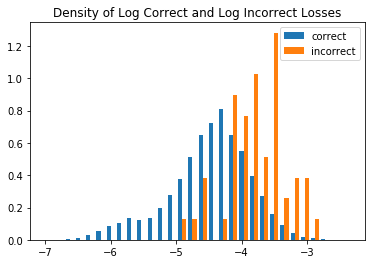


FPR = 10%
                                                 File  Detected    Fooled  \
0   logs_mnist_adv_05_20191224_14_09_23_834357__te...  1.000000  0.082040   
1   logs_mnist_adv_0_20191224_14_02_41_630783__tes...  1.000000  0.106319   
2   logs_mnist_adv_10_20191224_14_09_23_820164__te...  0.998780  0.070843   
3   logs_mnist_adv_15_20191224_14_09_29_196631__te...  0.991353  0.055432   
4   logs_mnist_adv_10000_20191224_14_57_26_013935_...  0.662084  0.008647   
5   logs_mnist_adv_1000_20191224_14_57_26_013433__...  0.663304  0.009424   
6   logs_mnist_adv_2_20191224_14_09_44_932102__tes...  0.955654  0.041131   
7   logs_mnist_adv_3_20191224_14_10_22_144123__tes...  0.888027  0.025721   
8   logs_mnist_adv_100_20191224_14_57_26_013646__t...  0.690687  0.012084   
9   logs_mnist_adv_35_20191224_14_10_34_216268__te...  0.881929  0.039468   
10  logs_mnist_adv_25_20191224_14_10_06_616283__te...  0.924279  0.039911   
11  logs_mnist_adv_45_20191224_14_11_08_153872__te...  0.837805  

In [8]:
patches_dir = "logs/mnist/new_recon_custom_weightreg_dropout/20191202_13:41:11:544060_/test"
regex = re.compile('\S*png_test.csv')
scale_out_of_ten = 5
visualize_patches_results(patches_dir, regex, scale_out_of_ten)

90th percentile of Correctly Classified Reconstruction Loss: 0.028666266
95th percentile of Correctly Classified Reconstruction Loss: 0.0370188675
99th percentile of Correctly Classified Reconstruction Loss: 0.05695482678000015


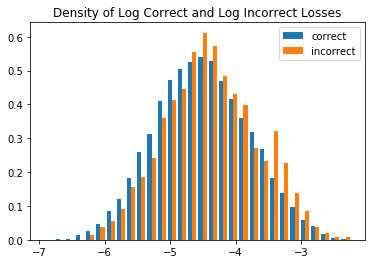


FPR = 10%
                                                 File  Detected    Fooled  \
0   logs_svhn_adv_tnk_20200225_17_02_48_042574__tr...  0.115864  0.044839   
1   logs_svhn_adv_00_20200225_17_00_01_069566__tra...  0.768765  0.178985   
2   logs_svhn_adv_tho_20200225_17_03_51_416523__tr...  0.114547  0.058920   
3   logs_svhn_adv_05_20200225_17_00_08_457050__tra...  0.699510  0.228106   
4   logs_svhn_adv_10_20200225_17_01_12_602654__tra...  0.623255  0.211059   
5   logs_svhn_adv_hun_20200225_17_02_28_957954__tr...  0.114547  0.103347   
6   logs_svhn_adv_15_20200225_17_00_24_300054__tra...  0.561370  0.221929   
7   logs_svhn_adv_20_20200225_17_00_33_295247__tra...  0.359946  0.208177   
8   logs_svhn_adv_25_20200225_17_00_47_507835__tra...  0.265986  0.188825   
9   logs_svhn_adv_ten_20200225_17_02_17_949714__tr...  0.142092  0.198831   
10  logs_svhn_adv_50_20200225_17_02_10_789800__tra...  0.180632  0.216906   
11  logs_svhn_adv_30_20200225_17_01_06_452384__tra...  0.264133  

In [9]:
patches_dir = "logs/svhn/single_pred_0_bg/20200220_17:42:42:547446_/test"
regex = re.compile('\S*png_test.csv')
scale_out_of_ten = 5
visualize_patches_results(patches_dir, regex, scale_out_of_ten)

90th percentile of Correctly Classified Reconstruction Loss: 0.038417149000000005
95th percentile of Correctly Classified Reconstruction Loss: 0.04486830825
99th percentile of Correctly Classified Reconstruction Loss: 0.058640876030000004


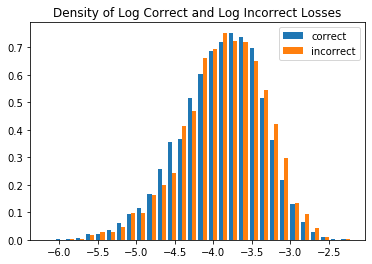


FPR = 10%
                                                 File  Detected    Fooled  \
0   logs_cifar10_adv_tenk_20200111_16_41_45_249320...  0.067444  0.030222   
1   logs_cifar10_adv_thousand_20200111_16_41_22_89...  0.066444  0.034889   
2   logs_cifar10_adv_hundred_20200111_16_41_05_447...  0.068444  0.075667   
3   logs_cifar10_adv_00_20200111_16_33_34_061935__...  0.740556  0.685778   
4   logs_cifar10_adv_05_20200111_16_33_34_061446__...  0.667111  0.662000   
5   logs_cifar10_adv_10_20200111_16_33_34_061579__...  0.637333  0.690556   
6   logs_cifar10_adv_15_20200111_16_33_34_061112__...  0.599444  0.629556   
7   logs_cifar10_adv_20_20200111_16_33_34_061447__...  0.559444  0.681222   
8   logs_cifar10_adv_25_20200111_16_33_34_061916__...  0.539333  0.661444   
9   logs_cifar10_adv_30_20200111_16_33_48_531391__...  0.525667  0.666444   
10  logs_cifar10_adv_35_20200111_16_35_18_621573__...  0.513889  0.667222   
11  logs_cifar10_adv_40_20200111_16_35_44_303662__...  0.452111  

In [10]:
patches_dir = "logs/cifar10/bg_recon_2/20191225_13:38:42:637171_/test"
regex = re.compile('\S*png_test.csv')
scale_out_of_ten = 5
visualize_patches_results(patches_dir, regex, scale_out_of_ten)

90th percentile of Correctly Classified Reconstruction Loss: 0.048225943
95th percentile of Correctly Classified Reconstruction Loss: 0.05629755
99th percentile of Correctly Classified Reconstruction Loss: 0.0727919092


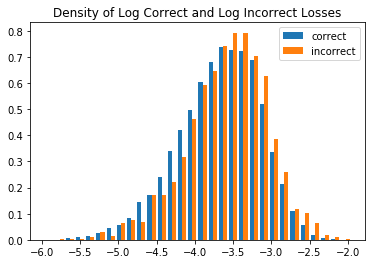


FPR = 10%
                                                 File  Detected    Fooled  \
0   logs_cifar10_bg0_adv_tenk_20200215_11_10_36_09...  0.064222  0.020111   
1   logs_cifar10_bg0_adv_thou_20200214_15_54_40_38...  0.068222  0.023111   
2   logs_cifar10_bg0_adv_hund_20200214_15_52_25_28...  0.065000  0.049333   
3   logs_cifar10_bg0_adv_00_20200214_15_08_18_1684...  0.925000  0.602333   
4   logs_cifar10_bg0_adv_05_20200214_15_09_17_5216...  0.888556  0.618444   
5   logs_cifar10_bg0_adv_15_20200214_15_09_58_9462...  0.858778  0.525333   
6   logs_cifar10_bg0_adv_10_20200214_15_09_58_1633...  0.861000  0.614444   
7   logs_cifar10_bg0_adv_20_20200214_15_10_32_9266...  0.812667  0.682778   
8   logs_cifar10_bg0_adv_25_20200214_15_10_31_1785...  0.807000  0.686000   
9   logs_cifar10_bg0_adv_30_20200214_15_11_11_7145...  0.755444  0.539444   
10  logs_cifar10_bg0_adv_35_20200214_15_11_02_0817...  0.720667  0.714000   
11  logs_cifar10_bg0_adv_45_20200214_15_12_01_6452...  0.682778  

In [11]:
patches_dir = "logs/cifar10/bg_recon_0/20191024_14:00:15:440334_/test"
regex = re.compile('\S*png_test.csv')
scale_out_of_ten = 5
visualize_patches_results(patches_dir, regex, scale_out_of_ten)

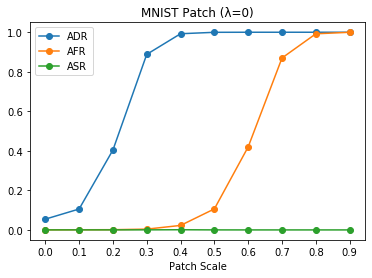

In [12]:
path = "logs/mnist/new_recon_custom_weightreg_dropout/20191202_13:41:11:544060_/test/"
file = "logs_mnist_adv_0_20191224_14_02_41_630783__test_saved_patch_png_test.csv"
df = pd.read_csv(path + file)
display_scaled_patch_success_detection_rates(df, 0, 0.02805054454999995, title="MNIST Patch (λ=0)", pdfout="naive.pdf")

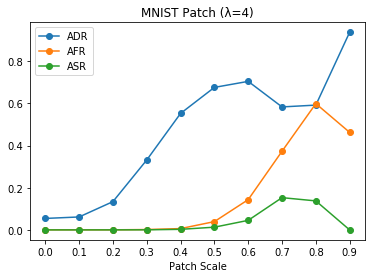

In [13]:
path = "logs/mnist/new_recon_custom_weightreg_dropout/20191202_13:41:11:544060_/test/"
file = "logs_mnist_adv_4_20191224_14_10_52_515839__test_saved_patch_png_test.csv"
df = pd.read_csv(path + file)
display_scaled_patch_success_detection_rates(df, 0, 0.02805054454999995, title="MNIST Patch (λ=4)", pdfout="adaptive.pdf")

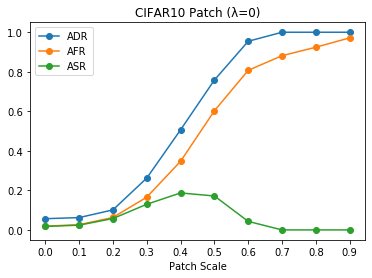

In [14]:
path = "logs/cifar10/bg_recon_0/20191024_14:00:15:440334_/test/"
file = "logs_cifar10_bg0_adv_00_20200214_15_08_18_168464__train_saved_patch_png_test.csv"
df = pd.read_csv(path + file)
display_scaled_patch_success_detection_rates(df, 0, 0.05629755, title="CIFAR10 Patch (λ=0)", pdfout="naive.pdf")

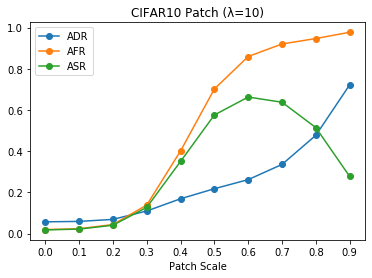

In [15]:
path = "logs/cifar10/bg_recon_0/20191024_14:00:15:440334_/test/"
file = "logs_cifar10_bg0_adv_ten_20200214_15_52_25_272192__train_saved_patch_png_test.csv"
df = pd.read_csv(path + file)
display_scaled_patch_success_detection_rates(df, 0, 0.05629755, title="CIFAR10 Patch (λ=10)", pdfout="adaptive.pdf")